In [1]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
!pip install librosa
!pip install SoundFile
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.9 MB/s eta 0:00:00


In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [3]:
# This will download the training audio/annotations.
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data files
downloaded = drive.CreateFile({'id':"1TjujGTMC98a4d0smt0D8Ff3ohDOtJzEk"})
downloaded.GetContentFile('Colab_Data.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Colab_Data.zip', 'r') as zip_file:
    zip_file.extractall()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import librosa
print(librosa.__version__)
import glob
import os
import pandas as pd
from xml.dom import minidom
from scipy import signal
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import random
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.patches as patches
import IPython.display as ipd
from IPython.display import Audio
import pickle

0.10.2.post1


In [6]:
# Paths
annotations_path = './Colab_Data/Annotations/'
original_audio_path = './Colab_Data/Audio/'
downsampled_audio_path = './Colab_Data/Downsampled_Audio/'


species_folder = './'
file_type = '.svl'
audio_extension = '.WAV'
training_files = './Colab_Data/train_multi.csv'


# Data hyper-parameters
# -----------------------------
downsample_rate = 20000
segment_duration = 2


# Spectrogram hyper-parameters
# -----------------------------
n_fft = 1024
hop_length = 256
n_mels = 64

# To decide on these, you might want to work on a single audio file
# to figure out what are suitable values so that you can see the different events
# you might want to work in conjunction with SonicVisualiser + loaded annotations
# for a particular file

#test_audio = '/content/Colab_Data/Audio/20241111_195700_AIMS.WAV'

#test_audio ='/content/Colab_Data/Audio/20241113_024800_CC.WAV'

test_audio ='/content/Colab_Data/sample.wav'

test_amp, test_sr = librosa.load(test_audio, sr=None)
print(f'test_sr == {test_sr}')

#partitioned_test_audio = test_amp[int(236.6468*test_sr):int(242.965*test_sr)]

partitioned_test_audio = test_amp[:int(6*test_sr)]

Audio(partitioned_test_audio, rate= test_sr)

test_sr == 48000


In [8]:
test_amp.shape

(695808,)

In [7]:
len(test_amp)

695808

[Text(0.5, 1.0, 'Mel-frequency Spectogram')]

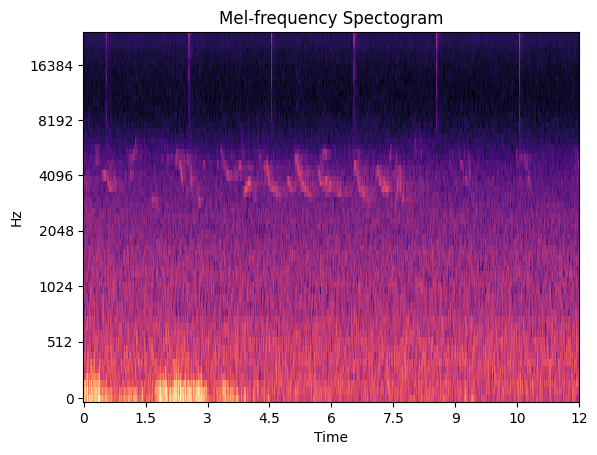

In [13]:

s = librosa.feature.melspectrogram(y=partitioned_test_audio, sr = test_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
s_db = librosa.power_to_db(s, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(s_db, x_axis='time', y_axis='mel', sr=test_sr, ax=ax)
ax.set(title='Mel-frequency Spectogram')



In [12]:
s_db.shape

(64, 1126)

In [10]:
# You most likely will not modify this
def get_annotation_information(file_name, audio_amps, sample_rate):

  # Process the .svl xml file
  xmldoc = minidom.parse(annotations_path+file_name+'.svl')
  itemlist = xmldoc.getElementsByTagName('point')
  idlist = xmldoc.getElementsByTagName('model')

  start_time = []
  end_time = []
  labels = []
  audio_file_name = ''

  print ('get annotation information')

  if (len(itemlist) > 0):

      print(file_name)

      # Iterate over each annotation in the .svl file (annotatation file)
      for s in itemlist:

          # Get the starting seconds from the annotation file. Must be an integer
          # so that the correct frame from the waveform can be extracted
          start_seconds = float(s.attributes['frame'].value)/sample_rate
          print('start_seconds', start_seconds)

          # Get the label from the annotation file
          label = str(s.attributes['label'].value)

          # If a file has a blank label then skip this annotation
          # to avoid mislabelling data
          if label == '':
              break

          # Get the duration from the annotation file
          annotation_duration_seconds = float(s.attributes['duration'].value)/sample_rate
          start_time.append(start_seconds)
          end_time.append(start_seconds+annotation_duration_seconds)
          labels.append(label)

  df_annotations = pd.DataFrame({'Start': start_time, 'End':end_time ,'Label': labels})
  return df_annotations, file_name+'.wav'

In [11]:
df, audio_file_name = get_annotation_information('20241113_024800_CC', test_amp,test_sr)


get annotation information
20241113_024800_CC
start_seconds 0.5973333333333334
start_seconds 2.176
start_seconds 7.082666666666666
start_seconds 8.789333333333333
start_seconds 13.333333333333334
start_seconds 13.866666666666667
start_seconds 18.261333333333333
start_seconds 29.376
start_seconds 33.77066666666666
start_seconds 48.61866666666667
start_seconds 58.32533333333333
start_seconds 83.584
start_seconds 84.672
start_seconds 107.11466666666666
start_seconds 108.30933333333333
start_seconds 120.91733333333333
start_seconds 123.47733333333333
start_seconds 127.44533333333334
start_seconds 128.0
start_seconds 136.384
start_seconds 137.536
start_seconds 150.63466666666667
start_seconds 152.68266666666668
start_seconds 169.96266666666668
start_seconds 171.66933333333333
start_seconds 175.36
start_seconds 181.184
start_seconds 185.64266666666666
start_seconds 187.28533333333334
start_seconds 191.44533333333334
start_seconds 200.27733333333333
start_seconds 202.34666666666666
start_seco

In [12]:
df.loc[0]

,0
Start,0.597333
End,5.568
Label,b


In [13]:
df

,Start,End,Label
0,0.597333,5.568000,b
1,2.176000,3.264000,w
2,7.082667,10.538667,b
3,8.789333,9.536000,w
4,13.333333,16.234667,b
...,...,...,...
80,1045.482667,1047.978667,w
81,1049.429333,1050.901333,w
82,1051.456000,1052.992000,w
83,1061.205333,1065.642667,b


In [14]:
def read_audio_file(file_name):
    amps, sr = librosa.load(file_name, sr=None)

    return amps, sr

In [15]:
# You most likely will not modify this
def getXY(audio_amplitudes, start_sec, annotation_duration_seconds,
          labels, sample_rate, verbose):

    if verbose == True:
        print ('start_sec', start_sec)
        print ('annotation_duration_seconds', annotation_duration_seconds)
        print ('segment_duration ', segment_duration )

    X_segments = []
    Y_labels = []

    # Calculate how many segments can be extracted based on the duration of
    # the annotated duration. If the annotated duration is too short then
    # simply extract one segment. If the annotated duration is long enough
    # then multiple segments can be extracted.
    if annotation_duration_seconds-segment_duration < 0:
        segments_to_extract = 1
    else:
        segments_to_extract = annotation_duration_seconds - segment_duration + 1

    if verbose:
        print ("segments_to_extract", segments_to_extract)

    for i in range (0, segments_to_extract):
        if verbose:
            print ('Semgnet {} of {}'.format(i, segments_to_extract-1))
            print ('*******************')

        # Set the correct location to start with.
        # The correct start is with respect to the location in time
        # in the audio file start+i*sample_rate
        start_data_observation = start_sec*sample_rate+i*(sample_rate)

        # The end location is based off the start
        end_data_observation = start_data_observation + (sample_rate*segment_duration)

        # This case occurs when something is annotated towards the end of a file
        # and can result in a segment which is too short.
        if end_data_observation > len(audio_amplitudes):
            continue

        # Extract the segment of audio
        X_audio = audio_amplitudes[start_data_observation:end_data_observation]

        if verbose == True:
            print ('start frame', start_data_observation)
            print ('end frame', end_data_observation)

        # Extend the segments and labels
        X_segments.append(X_audio)
        Y_labels.append(labels)

    return X_segments, Y_labels

In [16]:
def process_overlaps(df, mlb):
    # Get distinct time points
    time_points = sorted(set(df['Start']).union(df['End']))

    # Create time intervals
    time_intervals = [(time_points[i], time_points[i+1] ) for i in range(len(time_points)-1)]

    # Generate new dataframe with 6 columns: Start, End, a, b, n, w
    # Assign labels to each interval
    interval_data = []
    for start, end in time_intervals:
        # Get labels active in the current interval
        active_labels = df[(df['Start'] <= start) & (df['End'] > start)]['Label'].tolist()
        interval_data.append({'Start': start, 'End': end, 'labels': active_labels})

    # Apply MultiLabelBinarizer
    binary_labels = mlb.fit_transform([item['labels'] for item in interval_data])

    # Step 5: Create the final DataFrame
    multi_label_df = pd.DataFrame(binary_labels, columns=mlb.classes_)
    multi_label_df['Start'] = [item['Start'] for item in interval_data]
    multi_label_df['End'] = [item['End'] for item in interval_data]

    # Reorder columns
    multi_label_df = multi_label_df[['Start', 'End'] + mlb.classes_.tolist()]

    # Filter out rows where all label columns are zero
    label_columns = mlb.classes_.tolist()
    multi_label_df = multi_label_df[(multi_label_df[label_columns].sum(axis=1) > 0)]

    # Reset the index
    multi_label_df = multi_label_df.reset_index(drop=True)

    return multi_label_df

In [ ]:
mlb = MultiLabelBinarizer(classes=['a', 'b', 'n', 'w'])
multi_label_df = process_overlaps(df, mlb)
multi_label_df

,Start,End,a,b,n,w
0,0.597333,2.176000,0,1,0,0
1,2.176000,3.264000,0,1,0,1
2,3.264000,5.568000,0,1,0,0
3,7.082667,8.789333,0,1,0,0
4,8.789333,9.536000,0,1,0,1
...,...,...,...,...,...,...
127,1051.456000,1052.992000,0,1,0,1
128,1052.992000,1054.464000,0,1,0,0
129,1061.205333,1062.293333,0,1,0,0
130,1062.293333,1064.384000,0,1,0,1


In [ ]:
def create_dataset(verbose, mlb):

        # Initialise lists to store the X and Y values
        X_calls = []
        Y_calls = []

        if verbose == True:
            print ('Annotations path:',annotations_path+"*.svl")
            print ('Audio path',original_audio_path+"*.wav")

        # Read all names of the training files
        training_file_names = pd.read_csv(training_files, header=None)

        # Iterate over each annotation file
        for training_file in training_file_names.values:

            filename = training_file[0]

            print ('Processing file:',filename)

            print('Looking for this file: ', original_audio_path+filename+audio_extension)
            print('From these files here: ', original_audio_path+"*"+audio_extension)

            # Check if the .wav file exists before processing
            if original_audio_path+filename+audio_extension  in glob.glob(original_audio_path+"*"+audio_extension):
                print(f'Found file = {original_audio_path+filename+audio_extension }')

                print(f'filename= {filename}')

                # Read audio file
                signal, original_sample_rate = read_audio_file(original_audio_path+filename+audio_extension)

                #resample signal

                signal_downsampled = librosa.resample(y=signal, orig_sr=original_sample_rate, target_sr=downsample_rate)


                # Get the start/stop time of each annotated event
                df, audio_file_name = get_annotation_information(filename, signal_downsampled,
                                                                 original_sample_rate)

                # The dataframe above will have a number of annotated events
                # each with a unique label. (i.e. not multi-label)
                # You need to combine these events
                # that overlap in time so that events with two or more labels
                # appear as a single row with the corresponding label
                # for example [1,1,0,0] means that event a and b happened.
                # Store the result in a variable called mult_label_df
                # as this will be a dataframe where you'll create a muli-label
                # dataset! Do not modify the name of this dataframe as it will
                # be used below, and you will be assessed on this.
                multi_label_df = process_overlaps(df, mlb)

                # You need to print this dataframe as you will be assessed on this
                print(f'multi_label_df\n{multi_label_df}')

                # At this point you would have a processed dataframe.
                # each row would be an acoustic event with one or more targets.
                # There are 4 possible targets
                # a, b, n and w
                # a = anthropohony (including human speech)
                # b = biophony
                # n = absence of sound event
                # w = wind
                # So example rows could be:
                # Start = 10, End = 12, a = 1, b= 0, n = 0, w= 1
                # Start = 20, End = 22, a = 0, b= 1, n = 0, w= 1
                # Start = 30, End = 32, a = 0, b= 1, n = 0, w= 0

                print('Reading annotations...')
                for index, row in multi_label_df.iterrows():

                    start_seconds = int(round(row['Start']))
                    end_seconds = int(round(row['End']))

                    # You might want to handle special cases where the current
                    # start window overlaps into another labelled event
                    # this happens when start + duration overlaps with the next event
                    # in the dataframe

                    # Note there is another special case, where the current event
                    # overlaps with the next, but the next event doesn't introduce
                    # new sounds, this you can include the next event

                    # Combine all the labels for this row
                    labels = [row['a'], row['b'], row['n'], row['w']]
                    annotation_duration_seconds = end_seconds - start_seconds

                    # Extract augmented audio segments and corresponding binary labels
                    X_data, y_data = getXY(signal_downsampled, start_seconds,
                                                annotation_duration_seconds,
                                           labels, downsample_rate, verbose)

                    # Append the segments and labels
                    X_calls.extend(X_data)
                    Y_calls.extend(y_data)

        # Convert to numpy arrays
        X_calls, Y_calls = np.asarray(X_calls), np.asarray(Y_calls)

        return X_calls, Y_calls

In [ ]:
# Initialize MultiLabelBinarizer for binary encoding
mlb = MultiLabelBinarizer(classes=['a', 'b', 'n', 'w'])

X, Y = create_dataset(False, mlb)

Processing file: 20241112_030900_AIMS
Looking for this file:  ./Colab_Data/Audio/20241112_030900_AIMS.WAV
From these files here:  ./Colab_Data/Audio/*.WAV
Found file = ./Colab_Data/Audio/20241112_030900_AIMS.WAV
filename= 20241112_030900_AIMS
get annotation information
20241112_030900_AIMS
start_seconds 3.6773333333333333
start_seconds 10.789333333333333
start_seconds 11.2
start_seconds 21.82133333333333
start_seconds 28.634666666666668
start_seconds 30.14666666666667
start_seconds 32.218666666666664
start_seconds 34.608
start_seconds 41.44
start_seconds 48.010666666666665
start_seconds 48.029333333333334
start_seconds 52.17333333333333
start_seconds 59.77066666666666
start_seconds 60.498666666666665
start_seconds 67.424
start_seconds 82.97333333333333
start_seconds 90.98133333333334
start_seconds 100.89333333333333
start_seconds 196.336
start_seconds 207.16266666666667
start_seconds 208.264
start_seconds 211.13866666666667
start_seconds 216.86933333333334
start_seconds 228.85333333333

In [ ]:
# print the shape of X and Y
print(f'shape of X = {X.shape}')
print(f'shape of Y = {Y.shape}')

shape of X = (2083, 40000)
shape of Y = (2083, 4)


In [ ]:
# Save to pickle file
# Save X and Y once this preprocessing step is done as this is time consuming!
import pickle

with open('/content/drive/MyDrive/preprocessed_data.pkl', 'wb') as file:
    pickle.dump((X, Y), file)
print("Data saved successfully!")

Data saved successfully!


In [ ]:
# Load from pickle file to avoid running that pre-processing each time you want to run this script
with open('/content/drive/MyDrive/preprocessed_data.pkl', 'rb') as file:
    X_loaded, Y_loaded = pickle.load(file)

print("Data loaded successfully!")
print(f"X shape: {X_loaded.shape}, Y shape: {Y_loaded.shape}")

Data loaded successfully!
X shape: (2083, 40000), Y shape: (2083, 4)


In [ ]:
X_loaded

array([[-5.1298137e-03,  3.2109681e-03,  1.8724399e-02, ...,
         8.1002396e-03,  1.7762884e-02,  1.6484618e-02],
       [-1.4859557e-02, -1.3475742e-02, -1.5773579e-02, ...,
         7.3945487e-04, -3.6459137e-03, -1.1471229e-02],
       [-1.4859557e-02, -1.3475742e-02, -1.5773579e-02, ...,
         7.3945487e-04, -3.6459137e-03, -1.1471229e-02],
       ...,
       [-2.3454294e-01, -2.3622851e-01, -2.3250693e-01, ...,
         4.0212169e-02,  2.6519418e-02,  1.6229486e-02],
       [-2.6697630e-02, -3.8550541e-02, -6.3126728e-02, ...,
        -4.9742594e-02, -5.4892737e-02, -5.6766801e-02],
       [-3.0837232e-01, -3.0104518e-01, -2.9808697e-01, ...,
        -1.5290667e-03,  1.8742989e-04, -4.8664482e-03]], dtype=float32)

In [ ]:
Y_loaded

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
# convert to numpy arrays
X_loaded = np.array(X_loaded)
Y_loaded = np.array(Y_loaded)

# Plot distribution of the different events. this includes events where there is more than one target!

In [ ]:
# Find unique events combinations and their counts
unique_events, counts = np.unique(Y_loaded, axis=0, return_counts=True)

# Print the unique combinations and their frequencies
for row, count in zip(unique_events, counts):
    print(f"Combination: {row}, Count: {count}")

Combination: [0. 0. 0. 1.], Count: 65
Combination: [0. 0. 1. 0.], Count: 292
Combination: [0. 1. 0. 0.], Count: 556
Combination: [0. 1. 0. 1.], Count: 79
Combination: [1. 0. 0. 0.], Count: 988
Combination: [1. 0. 0. 1.], Count: 12
Combination: [1. 1. 0. 0.], Count: 91


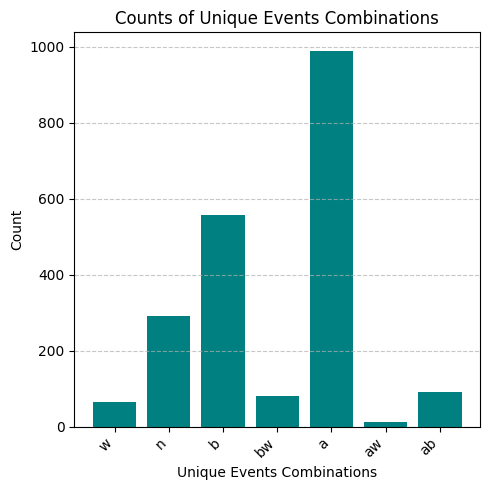

In [ ]:
# Corresponding labels
labels_map = ['a', 'b', 'n', 'w']

# Convert binary rows to label strings
def row_to_labels(row):
    return ''.join([labels_map[i] for i, val in enumerate(row.astype(int)) if val == 1])

# Generate labels for each unique row
formatted_labels = [row_to_labels(row) for row in unique_events]

# Plot the bar chart
plt.figure(figsize=(5, 5))
plt.bar(formatted_labels, counts, color='teal')

# Add labels and title
plt.xlabel('Unique Events Combinations')
plt.ylabel('Count')
plt.title('Counts of Unique Events Combinations')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save plot
plt.savefig("/content/drive/MyDrive/events_distributions.pdf", format="pdf", dpi=3000)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Convert the audio segments into spectrograms
spectrograms = []

for x in X_loaded:
  S = librosa.feature.melspectrogram(y=x, sr=downsample_rate, n_fft=n_fft, hop_length=hop_length, n_mels= n_mels)
  S_db = librosa.power_to_db(S, ref= np.max)
  spectrograms.append(S_db)

# Convert to numpy array
spectrograms = np.array(spectrograms)

In [ ]:
spectrograms.shape

(2083, 64, 157)

In [ ]:
spectrograms[0]

array([[ -0.640141  ,   0.        ,  -2.4222589 , ..., -19.550007  ,
        -16.335222  , -15.433588  ],
       [ -4.017284  ,  -0.99235964,  -1.6717243 , ..., -13.681158  ,
        -16.408026  , -16.887947  ],
       [-14.218146  , -12.794432  , -13.558498  , ..., -17.216915  ,
        -18.39027   , -21.251827  ],
       ...,
       [-56.935696  , -54.02225   , -53.622044  , ..., -53.77644   ,
        -51.74854   , -53.261177  ],
       [-54.803967  , -52.899677  , -53.96278   , ..., -53.59931   ,
        -53.94315   , -56.557217  ],
       [-61.10428   , -57.24922   , -55.766705  , ..., -56.274563  ,
        -56.819088  , -60.47299   ]], dtype=float32)

[Text(0.5, 1.0, 'Mel-frequency Spectogram')]

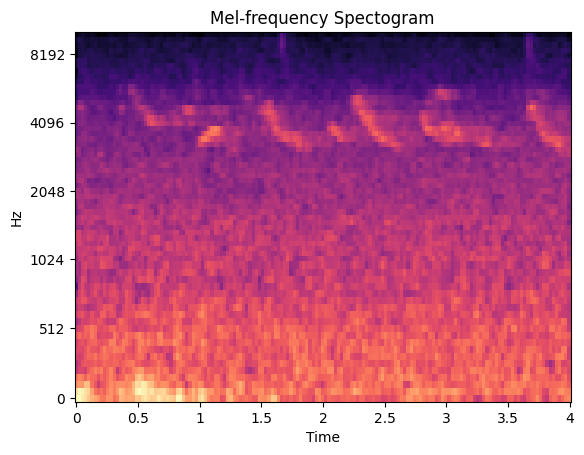

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(spectrograms[0], x_axis='time', y_axis='mel', sr=downsample_rate, ax=ax)
ax.set(title='Mel-frequency Spectogram')

In [ ]:
# Save to pickle file
import pickle

with open('/content/drive/MyDrive/segments_spectrograms.pkl', 'wb') as file:
    pickle.dump((spectrograms, Y_loaded), file)
print("Data saved successfully!")

Data saved successfully!


In [ ]:
# Load from pickle file to save time (next time you run the script)
import pickle
with open('/content/drive/MyDrive/segments_spectrograms.pkl', 'rb') as file:
    segments_spectrograms_loaded, targets_loaded = pickle.load(file)

print("Data loaded successfully!")

Data loaded successfully!


In [ ]:
# print the shapes of the spectrograms and targets
print(f'segments_spectrograms_loaded shape == {segments_spectrograms_loaded.shape}\ntargets shape == {targets_loaded.shape}')

segments_spectrograms_loaded shape == (2083, 64, 157)
targets shape == (2083, 4)


In [ ]:
# once you have spectrograms, you might want to delete  some old variables to save some RAM
# I'll only mention this hint once.
import gc

# Delete unnecessary variables
#del X_loaded, Y_loaded
#del X_augmented, Y_augmented
#del X_train, Y_train
#del spectrograms_augmented, targets_augmented
#del spectrograms, Y_loaded, X_loaded

# Explicitly run garbage collection
gc.collect()


31779

# Train and val splitting

In [ ]:
from sklearn.model_selection import train_test_split
seed = 123

X_train, X_val, Y_train, Y_val = train_test_split(segments_spectrograms_loaded, targets_loaded,
            test_size=0.2, random_state=seed,
            shuffle=True)


In [ ]:
# print shapes of training and validation data
print(f'X_train  shape === {X_train.shape}\nX_val shape === {X_val.shape}\nY_train === {Y_train.shape}\nY_val shape === {Y_val.shape}')

X_train  shape === (1666, 64, 157)
X_val shape === (417, 64, 157)
Y_train === (1666, 4)
Y_val shape === (417, 4)


# Perform data augmentation

In [ ]:
def rolling_augmentation(spectrogram, label, no_of_augmentations):
  #print(f'shape of spectrogram == {spectrogram.shape}')
  spectrograms_augmented = []
  targets_augmented = []

  for i in range(no_of_augmentations):
    # Randomly shift the spectrogram by some random value
    augmented= np.roll(spectrogram,shift = random.randint(0,len(spectrogram)-1))
    #print(f'shape of augmented =={ augmented.shape}')
    spectrograms_augmented.append(augmented)
    targets_augmented.append(label)

  return spectrograms_augmented, targets_augmented

In [ ]:
def augment_per_event(x_train,y_train):
    unique_events, counts = np.unique(y_train, axis=0, return_counts=True)

    final_spectrograms_augmented = []
    final_targets_augmented = []

    for unique_event, count in zip(unique_events, counts):
      if count < 800:
        no_to_augment = 800 - count
        matching_indices = np.where((y_train == unique_event).all(axis=1))[0]

        if no_to_augment < count:
          no_of_augmentations =1
          count = no_to_augment
        else:
          no_of_augmentations = int(no_to_augment/count)


        if no_of_augmentations > 0:
          for ind in matching_indices[:count]:
            spectrograms_augmented, targets_augmented = rolling_augmentation(x_train[ind], unique_event, no_of_augmentations)
            final_spectrograms_augmented.extend(spectrograms_augmented)
            final_targets_augmented.extend(targets_augmented)

    # Convert lists to numpy arrays
    final_spectrograms_augmented = np.asarray(final_spectrograms_augmented)
    final_targets_augmented = np.asarray(final_targets_augmented)

    #concatenate with the original dataset
    final_spectrograms_augmented = np.concatenate((x_train, final_spectrograms_augmented), axis=0)
    final_targets_augmented = np.concatenate((y_train, final_targets_augmented), axis=0)


    return final_spectrograms_augmented, final_targets_augmented




In [ ]:
X_augmented, Y_augmented = augment_per_event(X_train, Y_train)

In [ ]:
X_augmented.shape

(5410, 64, 157)

In [ ]:
Y_augmented.shape

(5410, 4)

# View the amount of training/validation data and their distributions

In [ ]:
def plotting_labels(labels, title):

  # Find unique events combinations and their counts
  unique_events, counts = np.unique(labels, axis=0, return_counts=True)

  # Print the unique combinations and their frequencies
  for row, count in zip(unique_events, counts):
      print(f"Combination: {row}, Count: {count}")

  # Corresponding labels
  labels_map = ['a', 'b', 'n', 'w']

  # Convert binary rows to label strings
  def row_to_labels(row):
      return ''.join([labels_map[i] for i, val in enumerate(row.astype(int)) if val == 1])

  # Generate labels for each unique row
  formatted_labels = [row_to_labels(row) for row in unique_events]

  # Plot the bar chart
  plt.figure(figsize=(5, 5))
  plt.bar(formatted_labels, counts, color='teal')

  # Add labels and title
  plt.xlabel('Unique Events Combinations')
  plt.ylabel('Count')
  plt.title(f'{title} Labels Counts of Unique Events Combinations')
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Save plot
  plt.savefig(f"/content/drive/MyDrive/{title}_events_distributions.pdf", format="pdf", dpi=3000)

  # Show the plot
  plt.tight_layout()
  plt.show()

Combination: [0. 0. 0. 1.], Count: 768
Combination: [0. 0. 1. 0.], Count: 702
Combination: [0. 1. 0. 0.], Count: 800
Combination: [0. 1. 0. 1.], Count: 756
Combination: [1. 0. 0. 0.], Count: 800
Combination: [1. 0. 0. 1.], Count: 792
Combination: [1. 1. 0. 0.], Count: 792


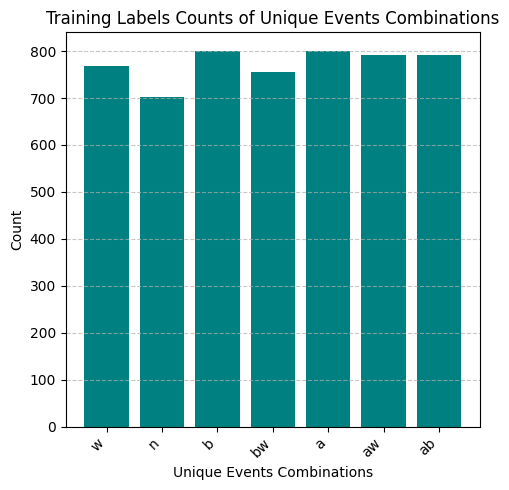

In [ ]:
# Plot training labels
plotting_labels(Y_augmented, title='Training')

Combination: [0. 0. 0. 1.], Count: 17
Combination: [0. 0. 1. 0.], Count: 58
Combination: [0. 1. 0. 0.], Count: 109
Combination: [0. 1. 0. 1.], Count: 16
Combination: [1. 0. 0. 0.], Count: 189
Combination: [1. 0. 0. 1.], Count: 3
Combination: [1. 1. 0. 0.], Count: 25


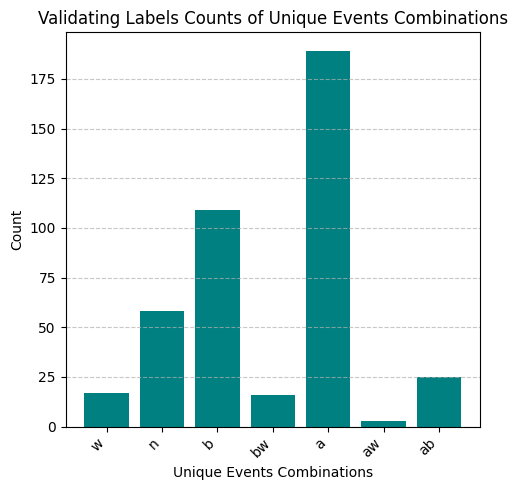

In [ ]:
# Plot validation labels
plotting_labels(Y_val, title='Validating')

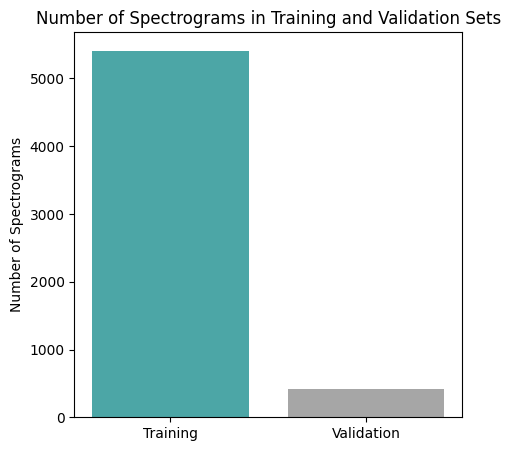

In [ ]:
# Number of samples in training and validation datasets
num_train_samples = X_augmented.shape[0]
num_val_samples = X_val.shape[0]

# Plot a bar chart
plt.figure(figsize=(5, 5))
plt.bar(['Training', 'Validation'], [num_train_samples, num_val_samples], color=['teal', 'grey'], alpha=0.7)

# Add labels and title
plt.ylabel('Number of Spectrograms')
plt.title('Number of Spectrograms in Training and Validation Sets')

# Save plot
plt.savefig(f"/content/drive/MyDrive/spectrograms_training_val_distributions.pdf", format="pdf", dpi=3000)
plt.show()

# Display 5 spectrogram examples of each of the different types of targets

In [ ]:
# Display 5 spectrogram examples of each of the different types of targets
# in each case view the spectrogram and display the target. Note that some
# events are multi-label, so you need to show 5 examples for each different
# multi/single event

In [17]:
def plot_spectrograms(spectrograms, labels, sr, no_of_plots):
    # Find unique events combinations and their counts
    unique_events, _ = np.unique(labels, axis=0, return_counts=True)

    # Corresponding labels
    labels_map = ['a', 'b', 'n', 'w']

    # Convert binary rows to label strings
    def row_to_labels(row):
        return ''.join([labels_map[i] for i, val in enumerate(row.astype(int)) if val == 1])

    # Generate labels for each unique row
    formatted_labels = [row_to_labels(row) for row in unique_events]

    for id, target_row in enumerate(unique_events):
      # Find the indices of rows that match the target row
      matching_indices = np.where((labels == target_row).all(axis=1))[0]

      formatted_label = formatted_labels[id]

      # Create a single figure with 5 subplots in a single row
      fig, axes = plt.subplots(1, 5, figsize=(20, no_of_plots))

      for index, label_index in enumerate(matching_indices[:no_of_plots]):
          # Extract the spectrogram
          s_db = spectrograms[label_index]

          # Plot on the corresponding axis
          ax = axes[index]
          img = librosa.display.specshow(s_db, x_axis='time', y_axis='mel', sr=sr, ax=ax)
          ax.set_title(f'{index+1}: {formatted_label} :{target_row} Presence')
          fig.colorbar(img, ax=ax, format="%+2.0f dB")

      # Adjust layout
      plt.tight_layout()

      # Save plot
      #plt.savefig(f"/content/drive/MyDrive/unique_events_samples_spectrograms.pdf", format="pdf", dpi=3000)

      plt.show()


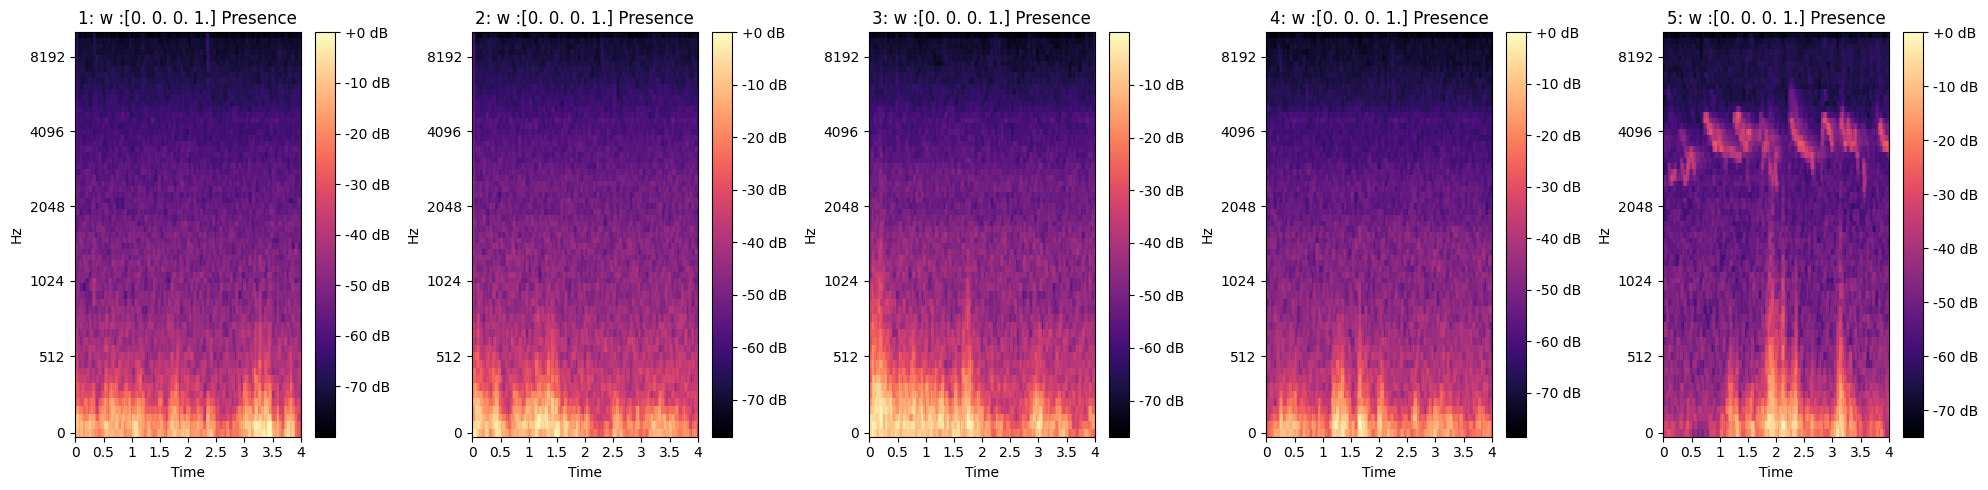

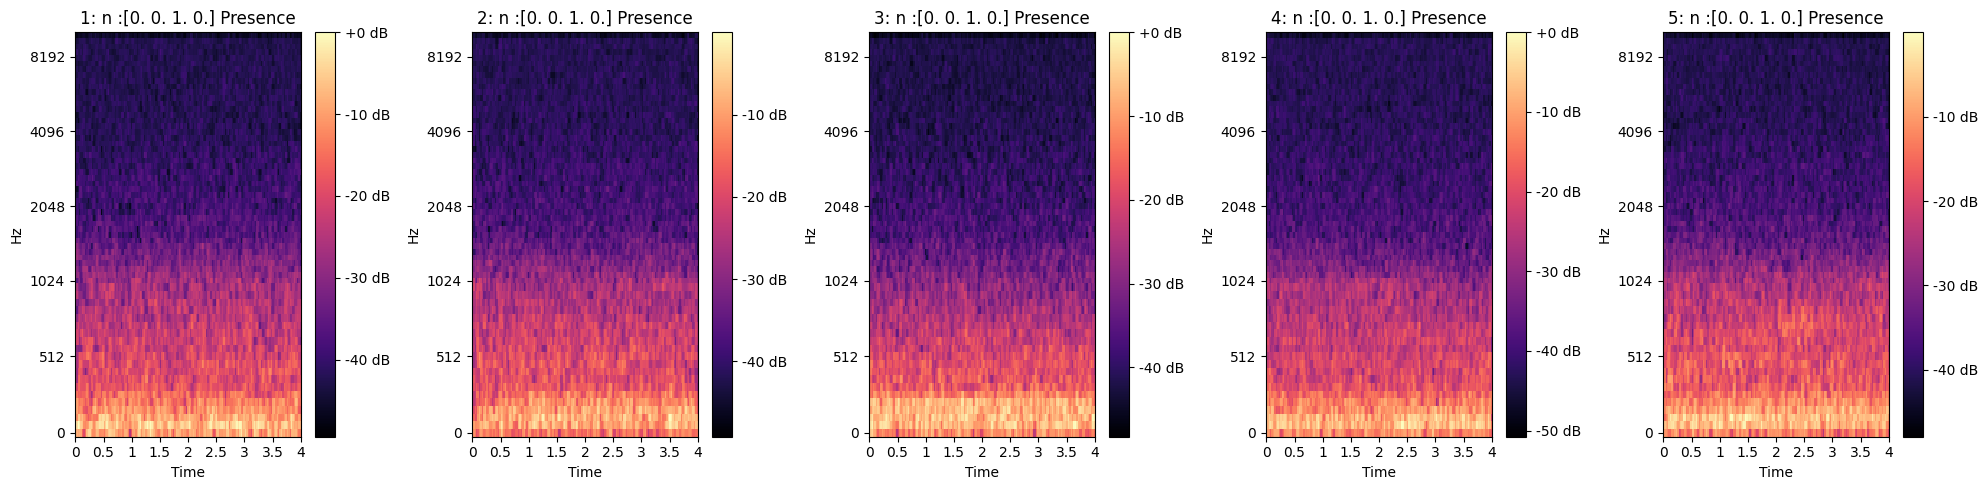

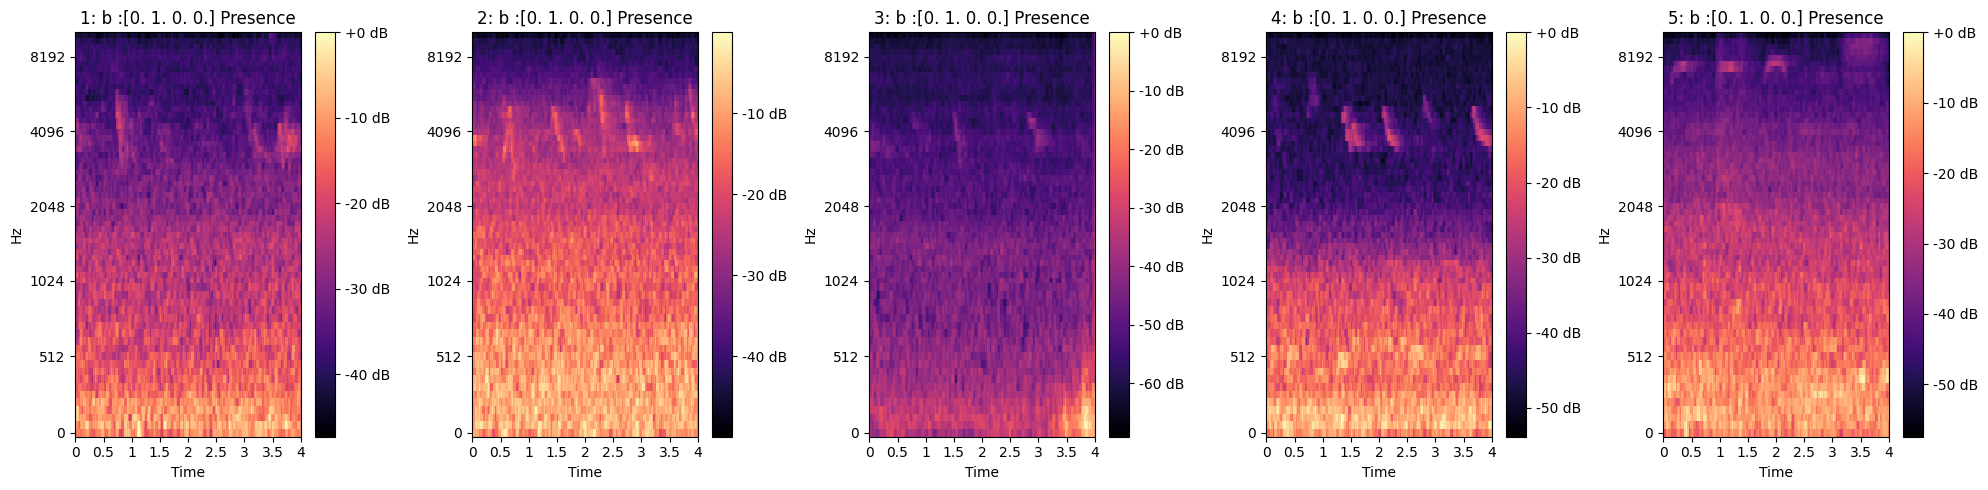

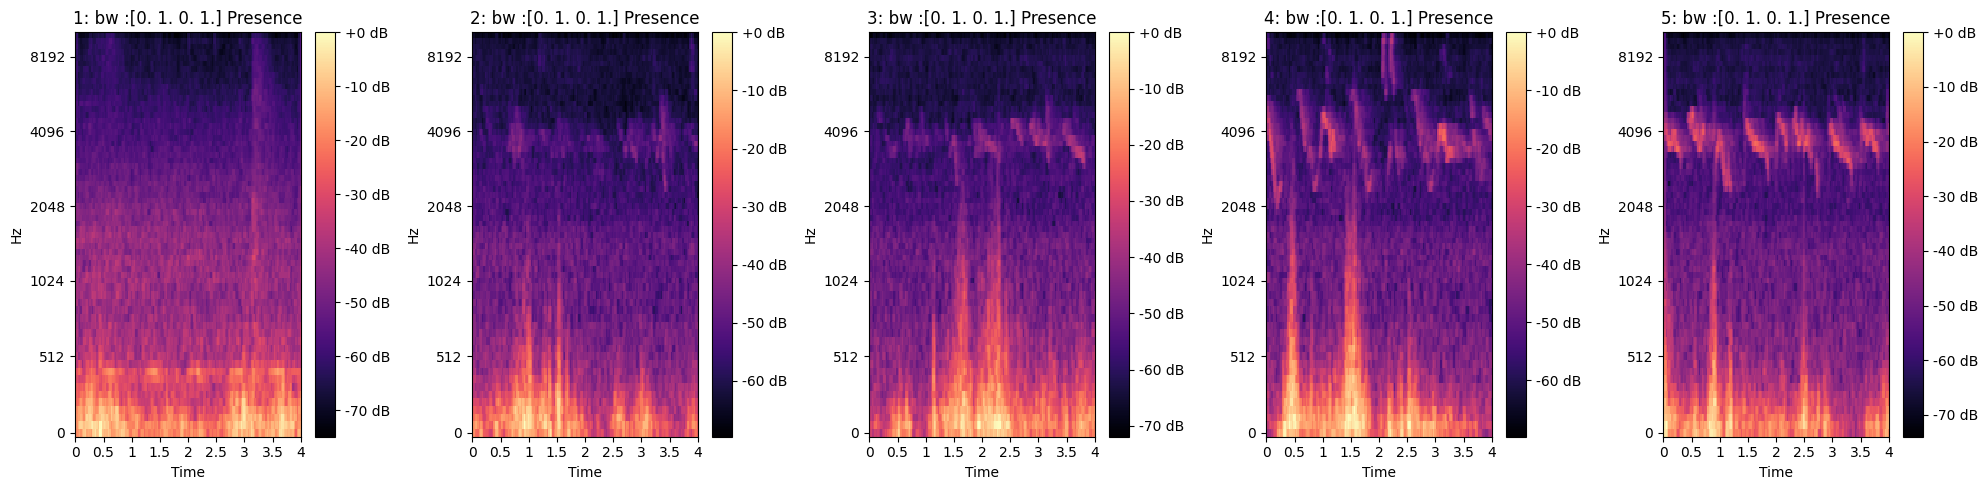

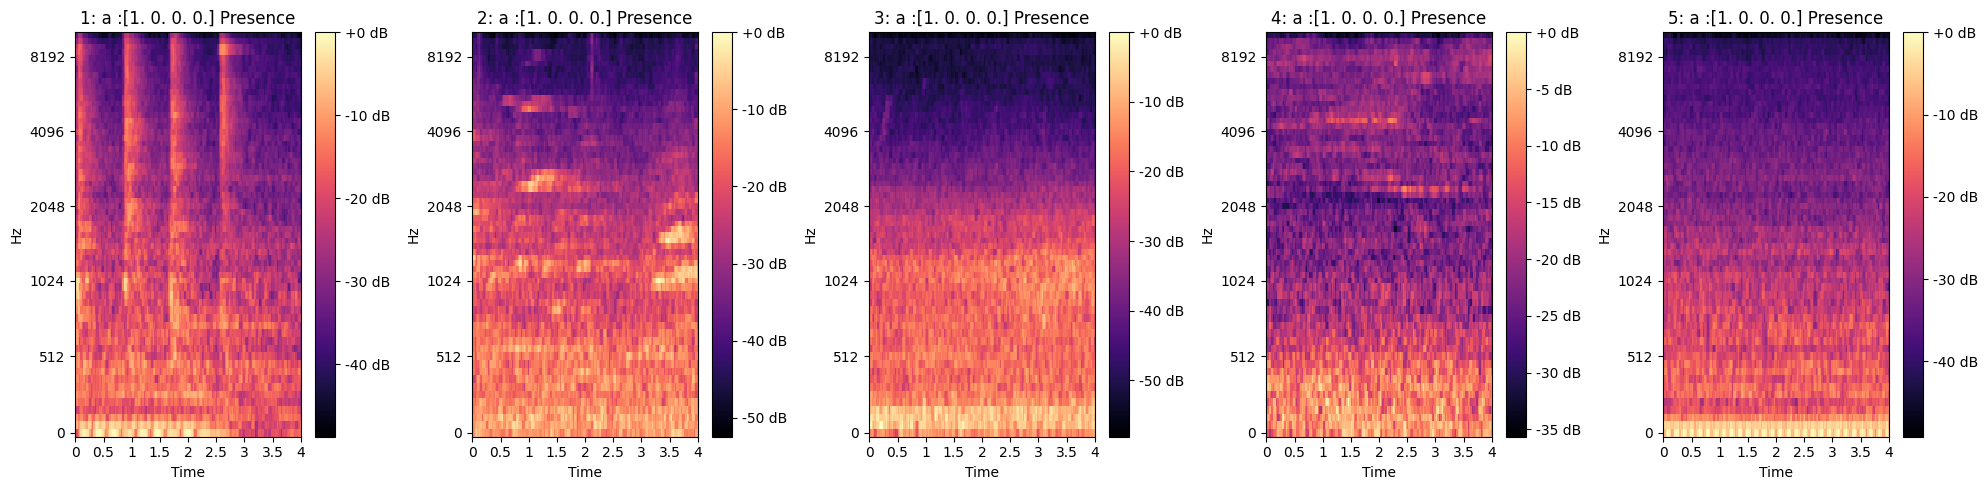

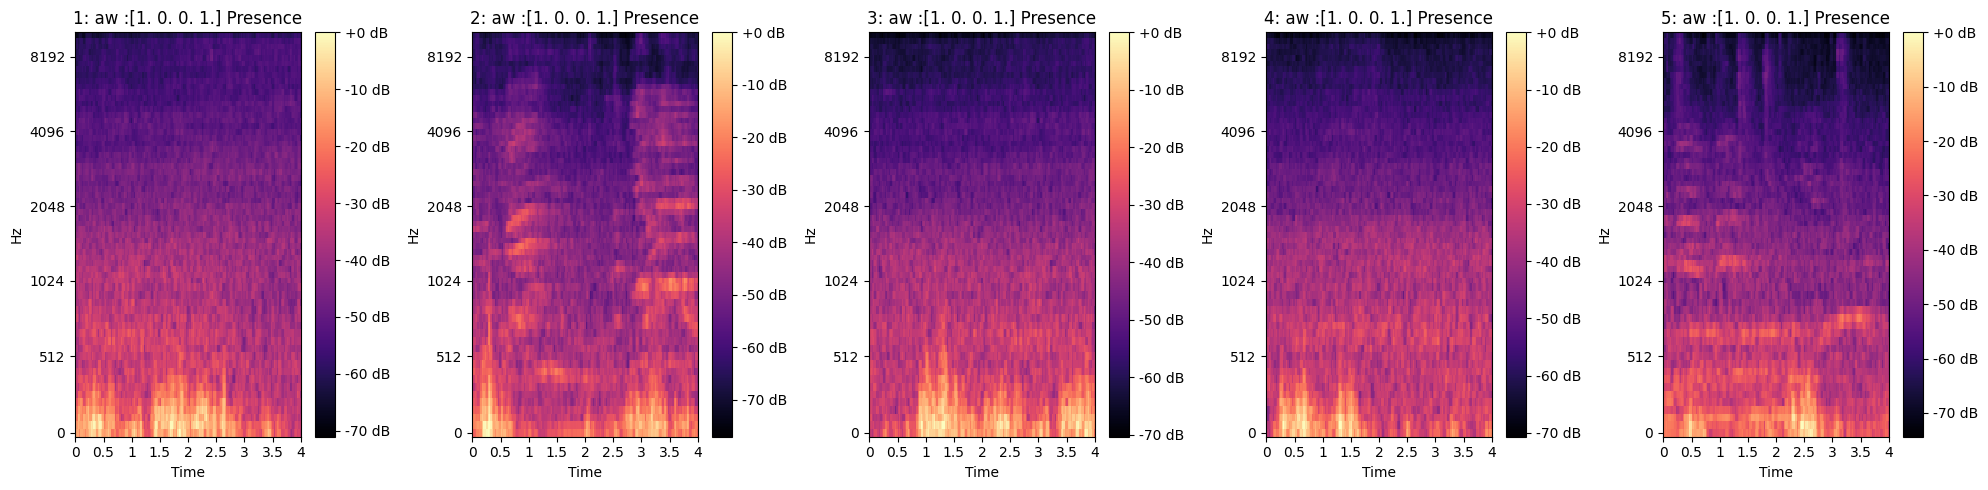

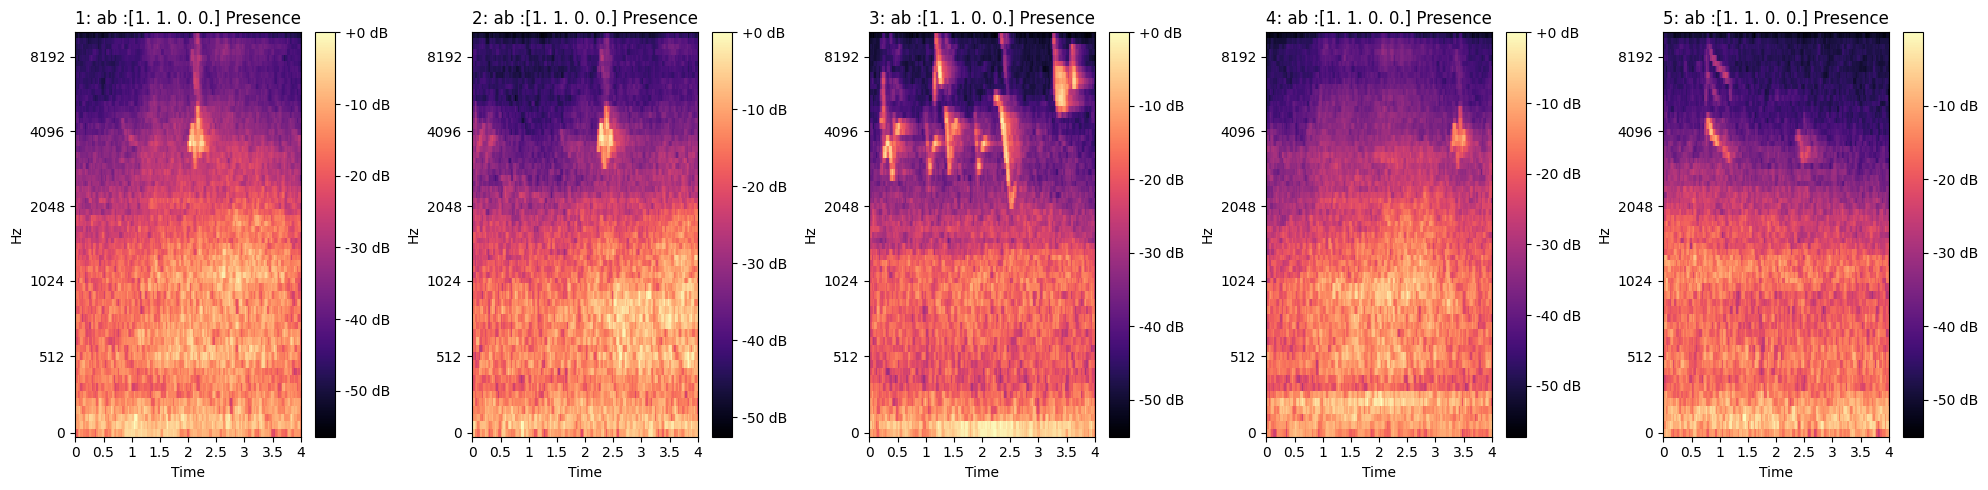

In [ ]:
# Combination: [0. 0. 0. 1.],
# Combination: [0. 0. 1. 0.],
# Combination: [0. 1. 0. 0.],
# Combination: [0. 1. 0. 1.],
# Combination: [1. 0. 0. 0.],
# Combination: [1. 0. 0. 1.],
# Combination: [1. 1. 0. 0.],

plot_spectrograms(spectrograms= X_augmented, labels = Y_train, sr= downsample_rate, no_of_plots=5)

# Normalize the Spectrograms

In [18]:
# Min-max Normalization
def normalize_spectrograms(spectrograms):
  normalized_spectrograms =[]
  for spectrogram in spectrograms:
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)
    normalized_spectrogram = (spectrogram - min_val) / (max_val - min_val)

    normalized_spectrograms.append(normalized_spectrogram)

  return np.asarray(normalized_spectrograms)


In [ ]:
X_augmented = normalize_spectrograms(X_augmented)
X_val = normalize_spectrograms(X_val)

# Add dimension to match the  Tensorflow depth requirement

In [19]:
def add_extra_dim(spectrograms):
    '''
    Add an extra dimension to the data so that it matches
    the input requirement of Tensorflow.
    '''
    spectrograms = np.reshape(spectrograms,
                              (spectrograms.shape[0],
                                spectrograms.shape[1],
                                spectrograms.shape[2],1))
    return spectrograms

In [ ]:
X_augmented = add_extra_dim(X_augmented)
X_val = add_extra_dim(X_val)
print(f'X_augmented shape  == {X_augmented.shape}')
print(f'X_val shape  == {X_val.shape}')

X_augmented shape  == (5410, 64, 157, 1)
X_val shape  == (417, 64, 157, 1)


# Train a neural network from randomly initialised weights

In [ ]:
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense
from keras.models import Model

inputs = Input(shape=(64,157,1))

x = inputs

x = Conv2D(filters = 32,kernel_size=4, activation='relu', input_shape=(64,157,1))(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 64,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 128,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
# x = Flatten()(x)
# x = Dense(4, activation='sigmoid')(x)

outputs = x

model_1 = Model(inputs, outputs)

print(model_1.summary());

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 157, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 154, 32)         │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 77, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 27, 74, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 10, 34, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 17, 128)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,576 (642.88 KB)

 Trainable params: 164,576 (642.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# train a neural network from randomly initialised weights
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Reshape, ConvLSTM2D
from keras.models import Model

inputs = Input(shape=(64,157,1))

x = inputs

x = Conv2D(filters = 32,kernel_size=4, activation='relu', input_shape=(64,157,1))(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 64,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 128,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Reshape((5, 17, 128,1))(x)
x = ConvLSTM2D(16, activation="relu",kernel_size=4,return_sequences=True)(x)
x = ConvLSTM2D(32, activation="relu",kernel_size=4)(x)
x = Flatten()(x)
x = Dense(4, activation='sigmoid')(x)

outputs = x

model_1 = Model(inputs, outputs)

print(model_1.summary());

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 157, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 61, 154, 32)         │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 77, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 74, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 34, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 17, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 5, 17, 128, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 5, 14, 125, 16)      │          17,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 11, 122, 32)         │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 42944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         171,780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,260 (1.73 MB)

 Trainable params: 452,260 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_1 = model_1.fit(X_augmented,
          Y_augmented,
          epochs=20,
          batch_size=32,
          validation_data=(X_val, Y_val))

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1175s 7s/step - accuracy: 0.3958 - loss: 0.5768 - val_accuracy: 0.6235 - val_loss: 0.5435
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1215s 7s/step - accuracy: 0.6337 - loss: 0.3744 - val_accuracy: 0.7602 - val_loss: 0.2974
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1170s 7s/step - accuracy: 0.6926 - loss: 0.2256 - val_accuracy: 0.8465 - val_loss: 0.2424
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1167s 7s/step - accuracy: 0.7001 - loss: 0.1614 - val_accuracy: 0.8489 - val_loss: 0.1996
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1220s 7s/step - accuracy: 0.7130 - loss: 0.1506 - val_accuracy: 0.8345 - val_loss: 0.2134
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1225s 7s/step - accuracy: 0.7310 - loss: 0.1411 - val_accuracy: 0.8729 - val_loss: 0.1827
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1231s 7s/step - accuracy: 0.7458 - loss: 0.1062 - val_accuracy: 0.8825 - val_loss: 0.1809
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1224s 7s/step - accuracy: 0.7345 - loss: 0.1041 - 

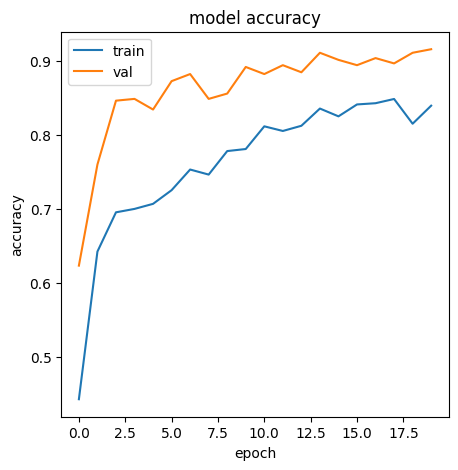

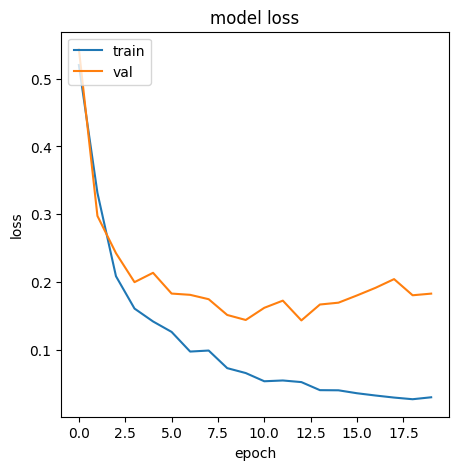

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# Save plot
plt.savefig(f"/content/drive/MyDrive/model_1_accuracy.pdf", format="pdf", dpi=3000)
plt.show()

# summarize history for loss
plt.figure(figsize=(5, 5))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f"/content/drive/MyDrive/model_1_loss.pdf", format="pdf", dpi=3000)
plt.show()

In [ ]:
# Save the model weights to your disk once you have your best model
model_1.save_weights('/content/drive/MyDrive/best_model_1_weights.weights.h5')
print("Model weights saved to disk.")


Model weights saved to disk.


In [21]:
# Write a function that takes in timestamps and groups the predicted
# events together. For example, if your model things that seconds
# 0,1,2,3 are all events of type [0,0,1,1] then group them togeter

def group_predicted_events(timestamps, predictions):
  grouped_events = []
  current_event = {
      'event' : None,
      'start' : None,
      'end' : None
  }

  for i, (timestamp, prediction) in enumerate(zip(timestamps, predictions)):
    prediction = list(prediction)
    #print(f'prediction\n{prediction}')
    if current_event['event'] is None:
      # Create a new group
      current_event['event'] = prediction
      current_event['start'] = timestamp
      current_event['end'] = timestamp
      #print(f'current_event {current_event}')
    elif prediction == current_event['event']:
      #print(f'prediction = {prediction}\ncurrent_event={current_event["event"]}\ntimestamp ={timestamp}')
      # update the end timestamp of the current event
      current_event['end'] = timestamp
    else:
      # append the current event to grouped_events and start the next event
      grouped_events.append(current_event)
      #print('starting a new event')
      current_event = {
          'event': prediction,
          'start': timestamp,
          'end': timestamp
      }

  if current_event['event'] is not None:
    #print('adding the last event')
    grouped_events.append(current_event)

  return grouped_events



In [ ]:
# write a function that takes your model and predicts on a single test file
# use this function signature:  def predict_single_file(test_file_name, test_path, model):
# this function should produce a plot, showing time on the x-axis, and it should
# inform the person viewing the plot as to what types of acoustic events occured
# during that time. The plot should be as informative as possible so someone
# will know what happened during this file

In [37]:
def convert_to_event_labels(predictions):
    predictions = np.asarray(predictions)
    binary_output = []
    max_val = np.max(predictions)

    if max_val < 5:
        if predictions.ndim == 1:
            # For 1D array
            binary_output = (predictions == predictions.max()).astype(int)
        else:
            # For 2D array
            binary_output = (predictions == predictions.max(axis=1, keepdims=True)).astype(int)
    else:
        for prediction in predictions:
            if prediction >= 5:
                binary_output.append(1)
            else:
                binary_output.append(0)

    return np.array(binary_output)

In [42]:
# Function to segment signal and create spectrograms
def create_spectrograms(signal, sample_rate, segment_duration, n_fft, hop_length, n_mels):
    segment_length = int(sample_rate * segment_duration)  # Number of samples per segment
    total_segments = len(signal) // segment_length  # Total number of complete segments
    spectrograms = []

    for i in range(total_segments):
        # Extract segment
        start = i * segment_length
        end = start + segment_length
        segment = signal[start:end]

        # Create spectrogram
        s = librosa.feature.melspectrogram(y=segment, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        s_db = librosa.power_to_db(s, ref=np.max)
        spectrograms.append(s_db)

    return np.asarray(spectrograms)

In [45]:
# Min-max Normalization
def normalize_spectrogram(spectrogram):
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)
    normalized_spectrogram = (spectrogram - min_val) / (max_val - min_val)

    return normalized_spectrogram


In [47]:
def predict_spectrograms(model, spectrograms):
    predictions = []

    for spectrogram in spectrograms:
        # Normalize the spectrogram
        spectrogram_normalized = normalize_spectrogram(spectrogram)

        # Expand dimensions to match the model's input shape
        spectrogram_input = np.expand_dims(np.expand_dims(spectrogram_normalized, axis=-1), axis=0)

        # Predict and append to the predictions list
        prediction = model.predict(spectrogram_input, verbose=0)
        predictions.append(prediction)

    # Convert predictions list to a NumPy array
    return np.vstack(predictions)


In [74]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_acoustic_events(event_dict,filename):
    # Map events to colors for visualization
    event_labels = {tuple([1, 0, 0, 0]): 'Anthrophony',
                    tuple([0, 1, 0, 0]): 'Biophony',
                    tuple([0, 0, 1, 0]): 'Nothing',
                    tuple([0, 0, 0, 1]): 'Wind',
                    tuple([1, 1, 0, 0]): 'Anthrophony|Biophony',
                    tuple([1, 1, 0, 1]): 'Anthrophony|Biophony|Wind',
                    tuple([1, 0, 0, 1]): 'Anthrophony|Wind',
                    tuple([0, 1, 0, 1]): 'Biophony|Wind',
                   }
    event_colors = {
        'Anthrophony': 'blue',
        'Biophony': 'orange',
        'Nothing': 'gray',
        'Wind': 'brown',
        'Anthrophony|Biophony': 'yellow',
        'Anthrophony|Biophony|Wind': 'green',
        'Anthrophony|Wind':'teal',
        'Biophony|Wind':'skyblue'
    }

    fig, ax = plt.subplots(figsize=(18, 6))

    # Add rectangles for each event
    for event in event_dict:
        label = event_labels.get(tuple(event['event']), 'Unknown')
        color = event_colors.get(label, 'gray')
        ax.add_patch(
            patches.Rectangle(
                (event['start'], 0),  # Start at (x=start, y=0)
                event['end'] - event['start'],  # Width (end - start)
                1,  # Height
                color=color,
                alpha=0.6,
                label=label if label not in [p.get_label() for p in ax.patches] else None
            )
        )

    # Configure plot
    ax.set_xlim(0, max(e['end'] for e in event_dict) + 2)
    ax.set_ylim(-1, 2)
    ax.set_yticks([])
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'{filename} Predicted Acoustic Events Over Time')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')
    plt.savefig(f"/content/drive/MyDrive/{filename}_predicted_plot.pdf", format="pdf", dpi=3000)
    plt.show()

In [75]:
def predict_single_file(test_file_name, test_path, model):
    downsample_rate = 20000
    segment_duration = 2


    # Spectrogram hyper-parameters
    # -----------------------------
    n_fft = 1024
    hop_length = 256
    n_mels = 64

    # Read audio file
    signal, original_sample_rate = read_audio_file(test_file_name)

    # Resample signal
    signal_downsampled = librosa.resample(y=signal, orig_sr=original_sample_rate, target_sr=downsample_rate)

    # Create Spectrograms
    spectrograms = create_spectrograms(signal_downsampled,downsample_rate, segment_duration,n_fft, hop_length, n_mels)

    # Normalize spectrograms and make predictions
    predictions = predict_spectrograms(model, spectrograms)

    # Convert to event labels
    event_labels = []
    for prediction in predictions:
      event_labels.append(convert_to_event_labels(prediction))

    event_labels = np.asarray(event_labels)

    # Create timestamps
    timestamps = np.arange(segment_duration,len(event_labels)+segment_duration,segment_duration)

    # Group events
    grouped_events = group_predicted_events(timestamps, event_labels)

    # Visualize grouped events
    plot_acoustic_events(grouped_events,test_file_name)



In [24]:
model_1.load_weights('/content/drive/MyDrive/best_model_1_weights.weights.h5')
print("Model weights loaded successfully.")

Model weights loaded successfully.


In [25]:
# do not modify
test3 = '1APBxL5lyAX_cV0U5BLkz3BSrhUKm7zaB'
test4 = '1ROfjh47uZtnK-HVNiwcbAECC6HIwYtmk'
test5 = '144H3yHYIxHH6v_JY_-EP2--X5U7PxwbX'
test6 = '1I_GeHEt0EdoAptUjh9obDOoXXNUm1Rwq'
test7 = '1AdLXsvvbgSPSI6IrvDY0cSDIpccbtx4B'
test8 = '1nKdVkDEV4v8RTONoPQR0xiepc6B6_JSi'
test9 = '13k_o2W62I9aQRWmubT-U5-lQcRm4w6oi'
test10 = '1z-60L-piAo96URDKpfY7jW3V0UWiHfAt'

In [27]:
# This will download the training audio/annotations.
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [28]:
# do not modify
downloaded = drive.CreateFile({'id':test3})
downloaded.GetContentFile('20241113_102700_AIMS.WAV')

downloaded = drive.CreateFile({'id':test4})
downloaded.GetContentFile('20241113_092100_AIMS.WAV')

downloaded = drive.CreateFile({'id':test5})
downloaded.GetContentFile('20241113_022700_CC.WAV')

downloaded = drive.CreateFile({'id':test6})
downloaded.GetContentFile('20241112_061800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test7})
downloaded.GetContentFile('20241112_035100.WAV')

downloaded = drive.CreateFile({'id':test8})
downloaded.GetContentFile('20241112_024800.WAV')

downloaded = drive.CreateFile({'id':test9})
downloaded.GetContentFile('20241112_024800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test10})
downloaded.GetContentFile('20241111_224500.WAV')

Predict on these files. You will be assessed on how well your model performs on these files and how informative your plot was at telling a story about what sounds happened in this file.

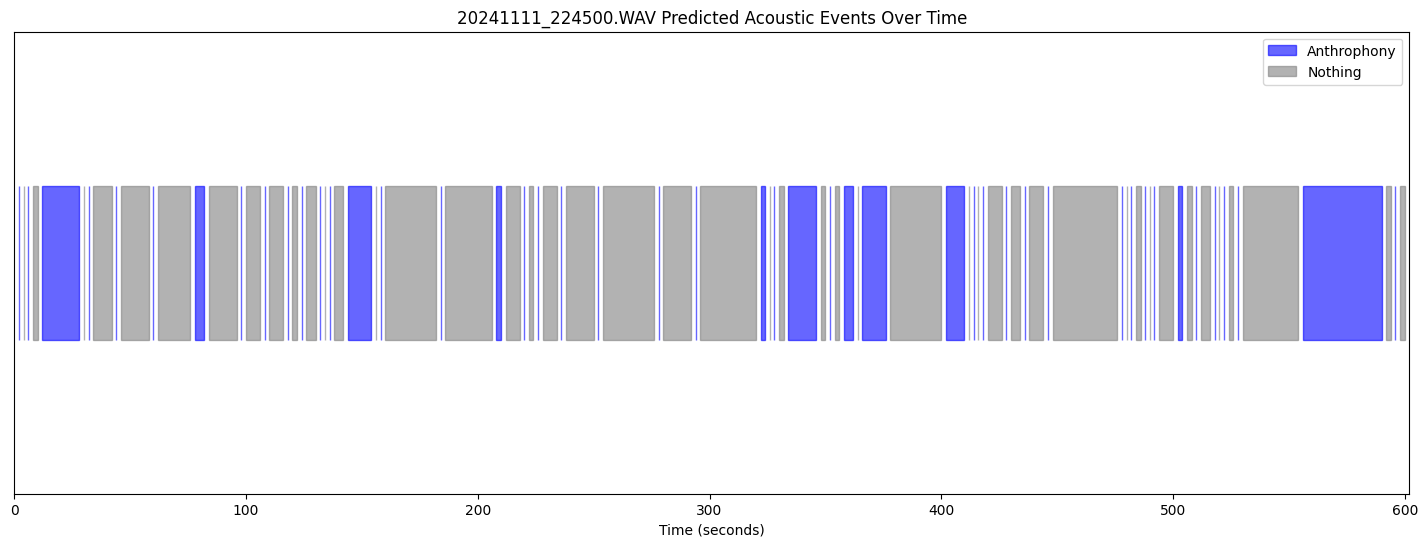

In [78]:
# do not modify
test_path = '.'
test_file_name = '20241111_224500.WAV'

predict_single_file(test_file_name, test_path, model_1)

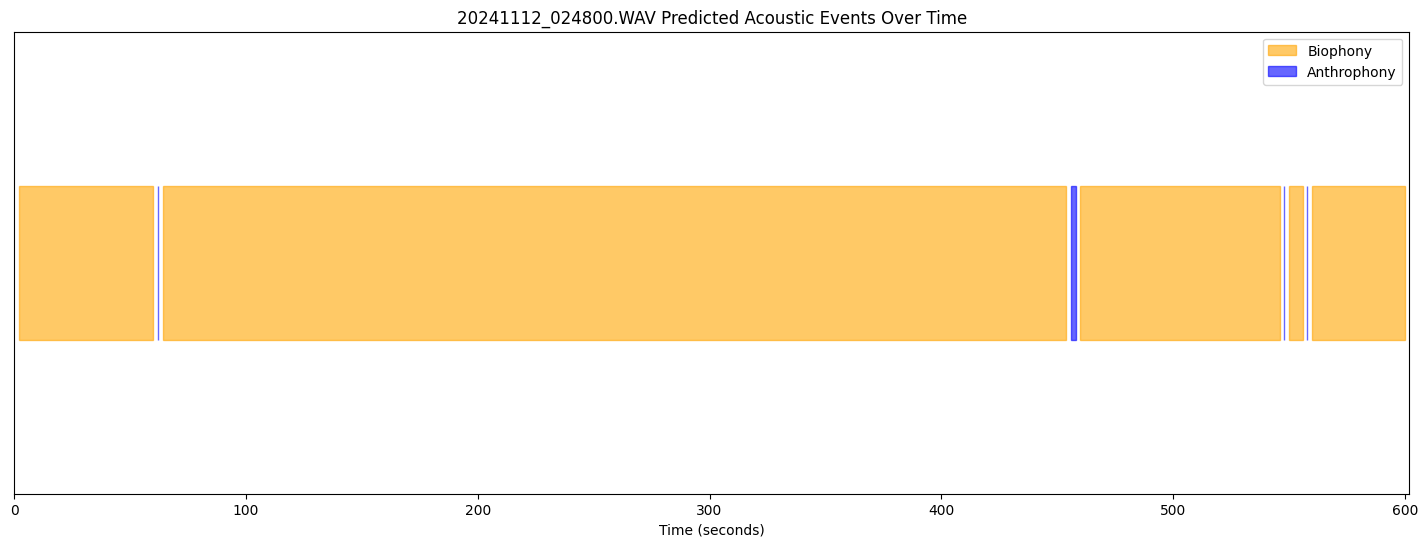

In [77]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800.WAV'

predict_single_file(test_file_name, test_path, model_1)

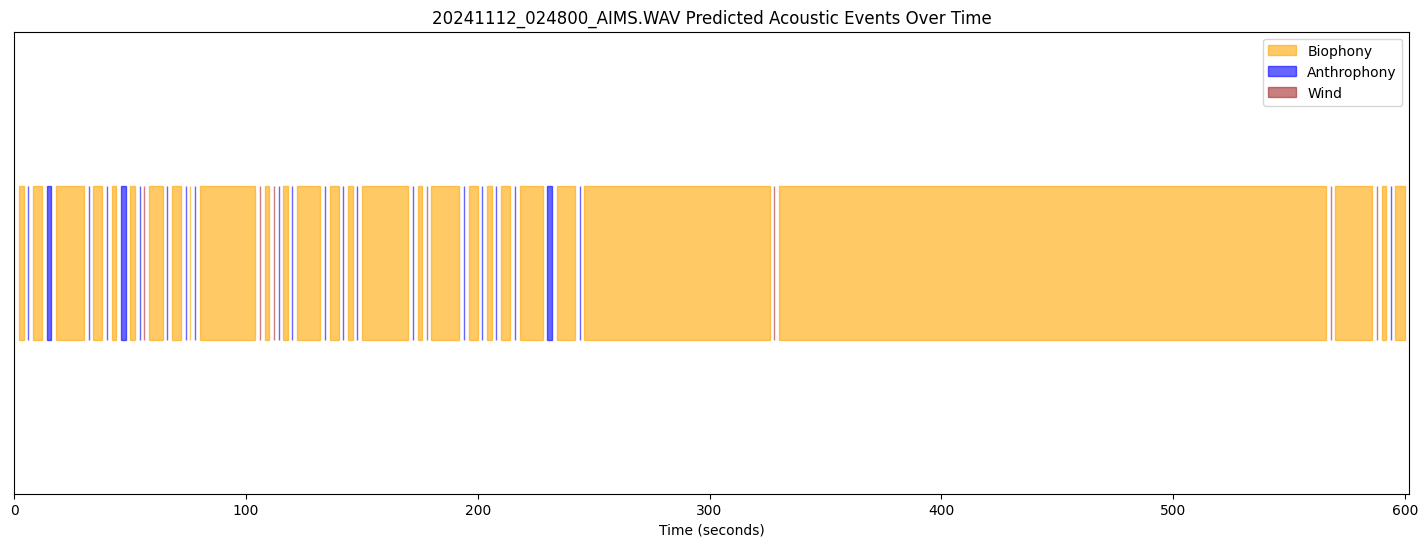

In [79]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_1)

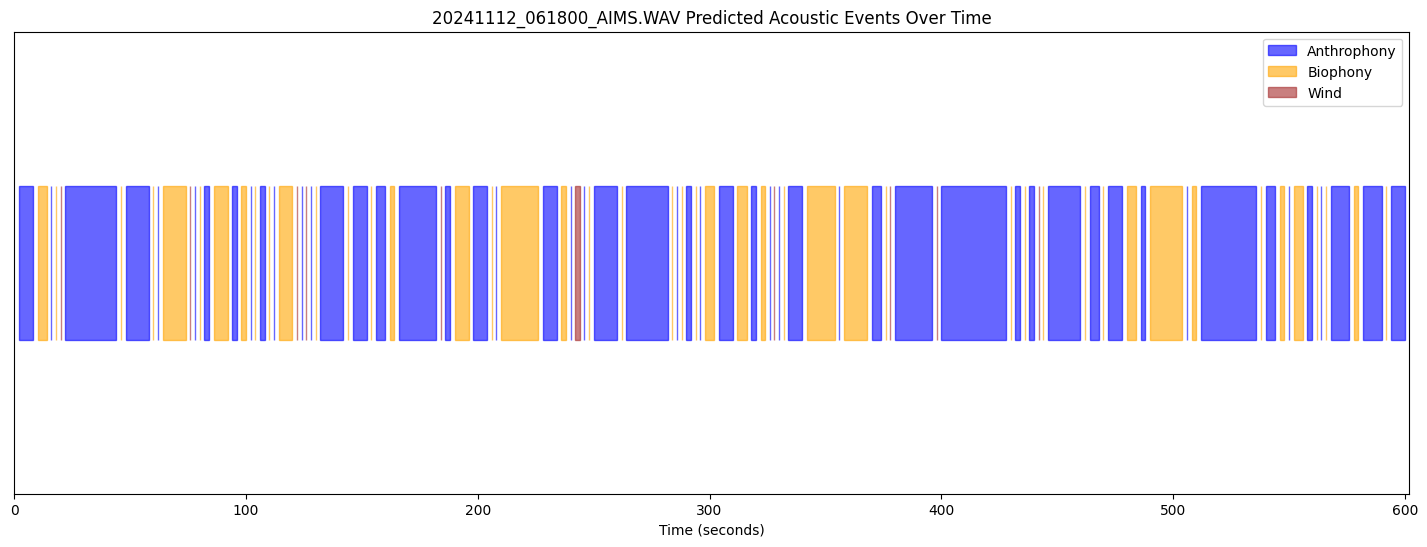

In [80]:
# do not modify
test_path = '.'
test_file_name = '20241112_061800_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_1)

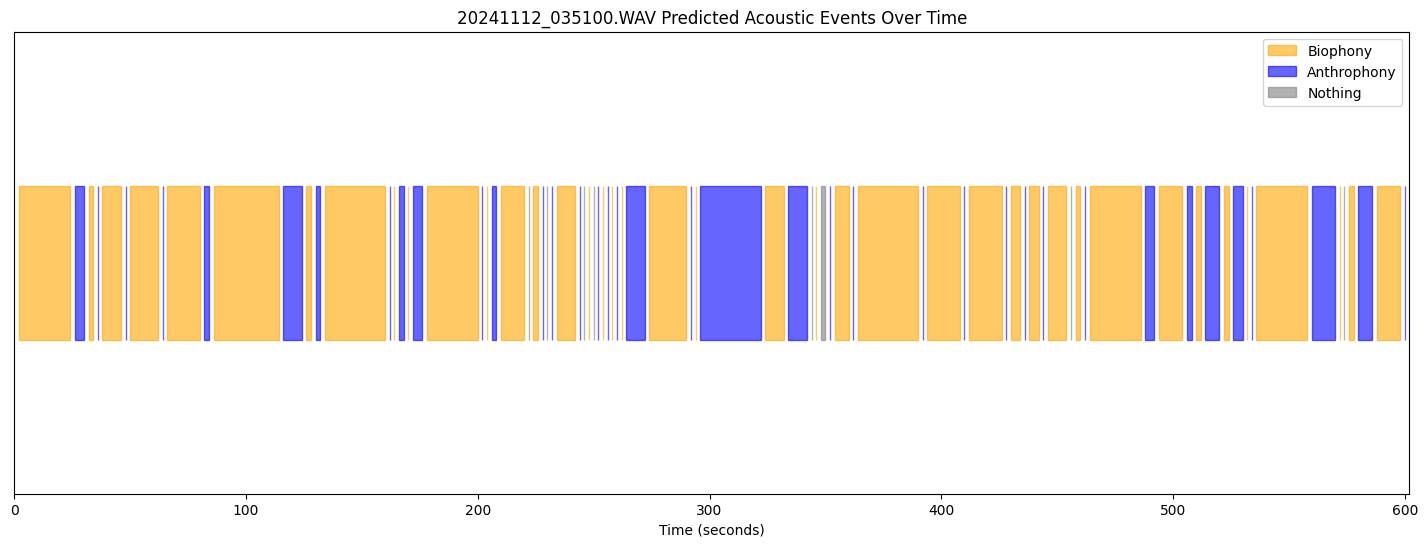

In [81]:
# do not modify
test_path = '.'
test_file_name = '20241112_035100.WAV'

predict_single_file(test_file_name, test_path, model_1)

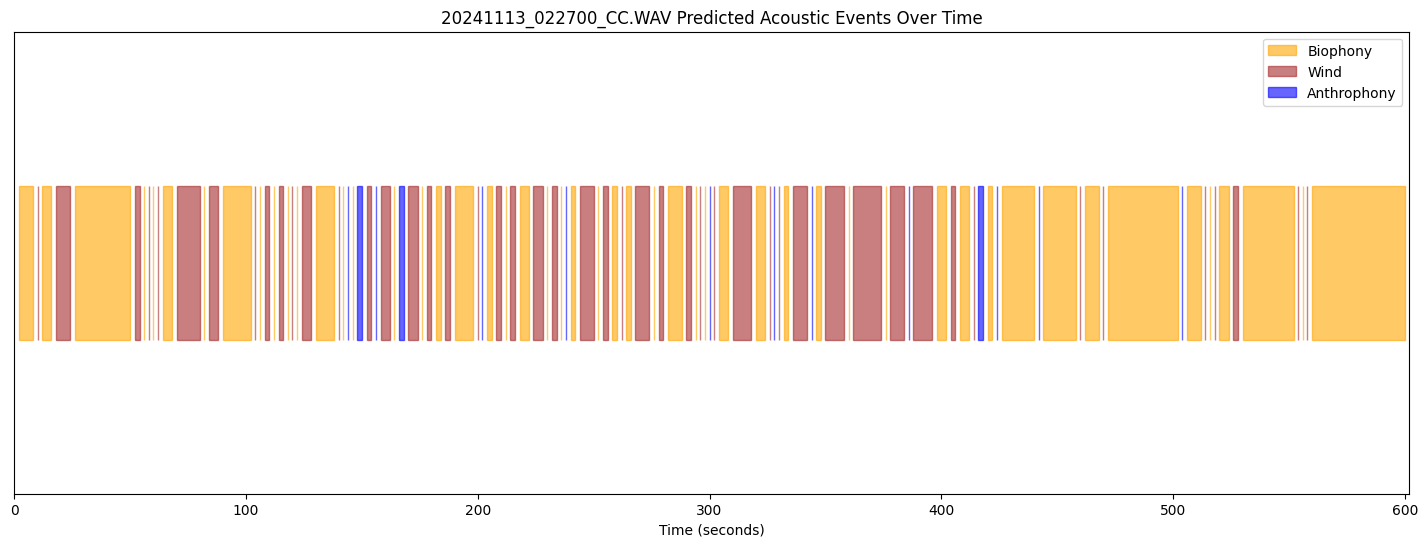

In [82]:
# do not modify
test_path = '.'
test_file_name = '20241113_022700_CC.WAV'

predict_single_file(test_file_name, test_path, model_1)

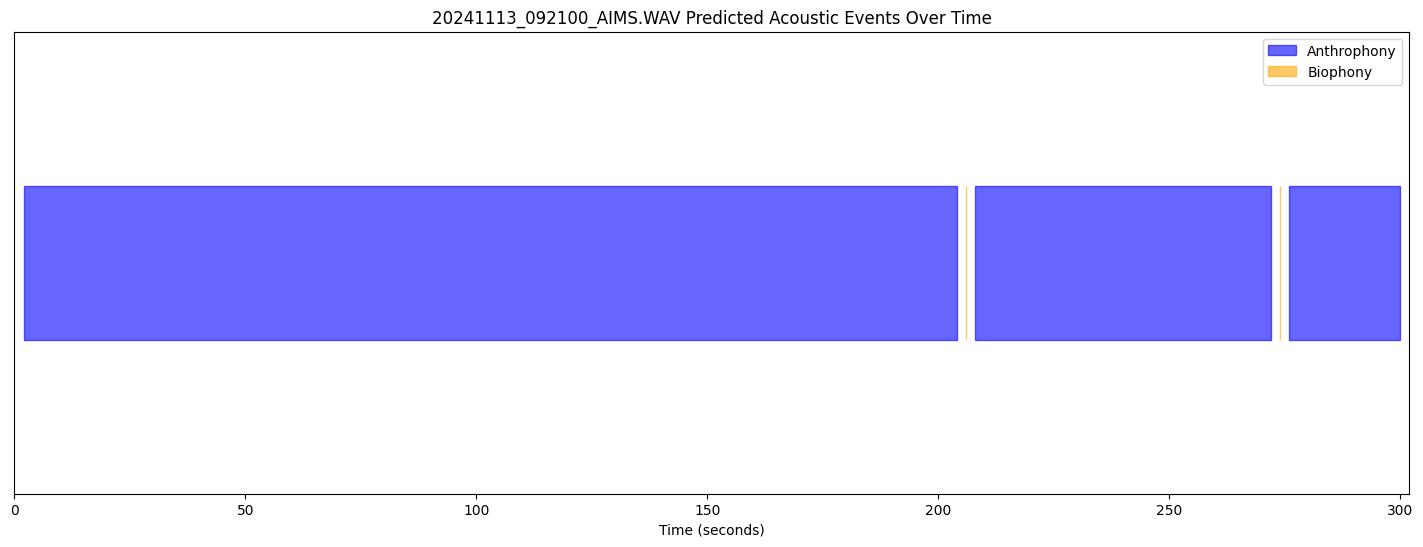

In [83]:
# do not modify
test_path = '.'
test_file_name = '20241113_092100_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_1)

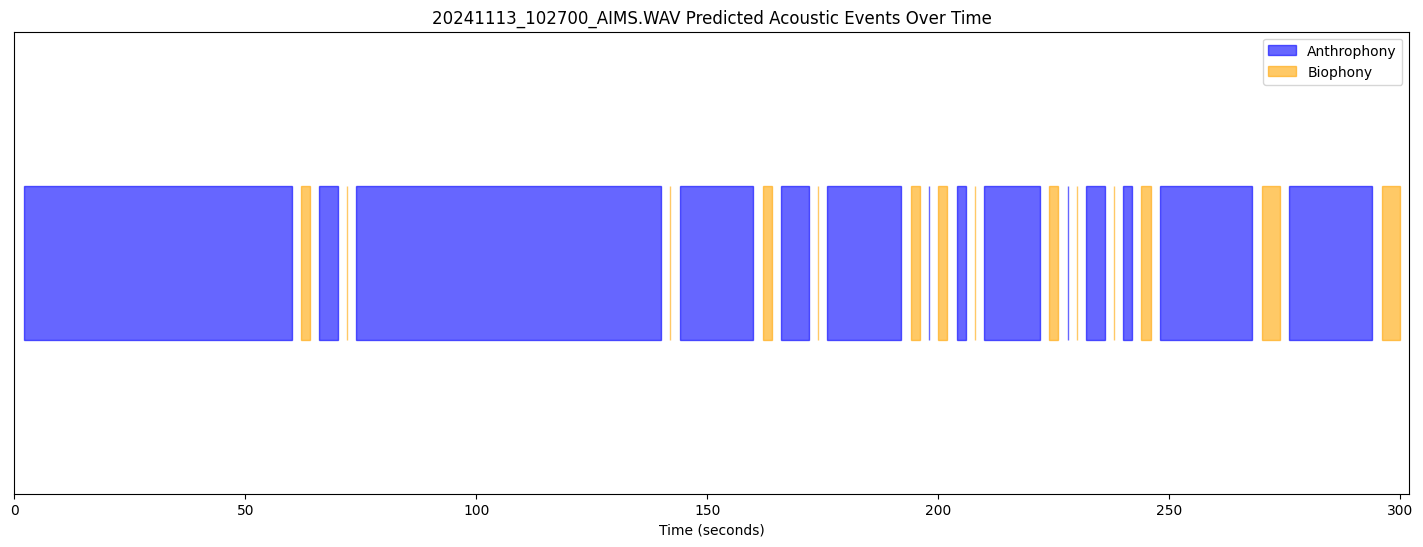

In [84]:
# do not modify
test_path = '.'
test_file_name = '20241113_102700_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_1)